# Prompt Chaining

Prompt chaining will help simply the task by decomposing the overall task into smaller steps. This can be helpful for the model because it breaks down the task into smaller, more manageable chunks, improving the accuracy of the overall system.

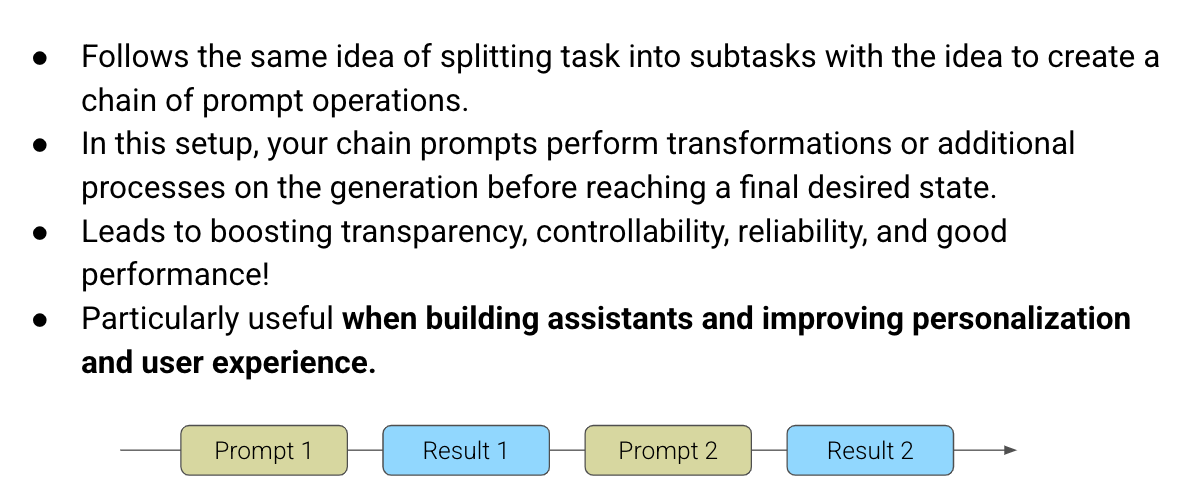


In [1]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")

from utils import *

Apply prompt chaining to our food menu chatbot.

Here is what we are building:

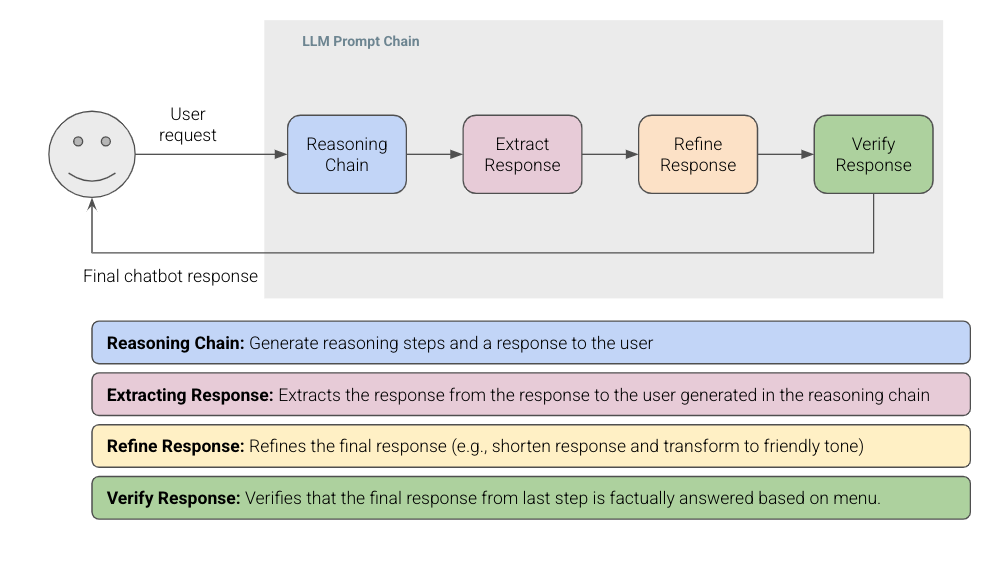

### Step 1: CoT Reasoning Steps

In [2]:
menu_delimiter = "<food_items>"
menu_delimiter_end = "</food_items>"

thinking_delimiter = "<thinking>"
thinking_delimiter_end = "</thinking>"

response_delimiter = "<response>"
response_delimiter_end = "</response>"

food_items = """
Menu: Kids Menu    
Food Item: Mini Cheeseburger
Price: $6.99
Vegan: N
Popularity: 4/5
Included: Mini beef patty, cheese, lettuce, tomato, and fries.

Menu: Appetizers
Food Item: Loaded Potato Skins
Price: $8.99
Vegan: N
Popularity: 3/5
Included: Crispy potato skins filled with cheese, bacon bits, and served with sour cream.

Menu: Appetizers
Food Item: Bruschetta
Price: $7.99
Vegan: Y
Popularity: 4/5
Included: Toasted baguette slices topped with fresh tomatoes, basil, garlic, and balsamic glaze.

Menu: Main Menu
Food Item: Grilled Chicken Caesar Salad
Price: $12.99
Vegan: N
Popularity: 4/5
Included: Grilled chicken breast, romaine lettuce, Parmesan cheese, croutons, and Caesar dressing.

Menu: Main Menu
Food Item: Classic Cheese Pizza
Price: $10.99
Vegan: N
Popularity: 5/5
Included: Thin-crust pizza topped with tomato sauce, mozzarella cheese, and fresh basil.

Menu: Main Menu
Food Item: Spaghetti Bolognese
Price: $14.99
Vegan: N
Popularity: 4/5
Included: Pasta tossed in a savory meat sauce made with ground beef, tomatoes, onions, and herbs.

Menu: Vegan Options
Food Item: Veggie Wrap
Price: $9.99
Vegan: Y
Popularity: 3/5
Included: Grilled vegetables, hummus, mixed greens, and a wrap served with a side of sweet potato fries.

Menu: Vegan Options
Food Item: Vegan Beyond Burger
Price: $11.99
Vegan: Y
Popularity: 4/5
Included: Plant-based patty, vegan cheese, lettuce, tomato, onion, and a choice of regular or sweet potato fries.

Menu: Desserts
Food Item: Chocolate Lava Cake
Price: $6.99
Vegan: N
Popularity: 5/5
Included: Warm chocolate cake with a gooey molten center, served with vanilla ice cream.

Menu: Desserts
Food Item: Fresh Berry Parfait
Price: $5.99
Vegan: Y
Popularity: 4/5
"""

In [3]:
def get_reasoning_step(user_query, food_items):

    system_message = f"""
    Your task is answer questions factually about a food menu, provided below and delimited by {menu_delimiter}{menu_delimiter_end}.

    Step 1: The first step is to check if the user is asking a question related to any type of food (even if that food item is not on the menu). If the question is about any type of food, we move on to Step 2 and ignore the rest of Step 1. If the question is not about food, then we send a response: "Sorry! I cannot help with that. Please let me know if you have a question about our food menu."

    Step 2: In this step, we check that the user question is relevant to any of the items on the food menu. You should check that the food item exists in our menu first. If it doesn't exist then send a kind response to the user that the item doesn't exist in our menu and then include a list of available but similar food items without any other details (e.g., price). The food items available are provided below and delimited by {menu_delimiter}{menu_delimiter_end}:

    {menu_delimiter}
    {food_items}
    {menu_delimiter_end}

    Step 3: If the item exist in our food menu and the user is requesting for specific information, provide that relevant information to the user using the food menu. Make sure to use a friendly tone and keep the response concise.

    Perform the following reasoning steps to send a response to the user:
    {thinking_delimiter}
    Step 1: <Step 1 reasoning>
    Step 2: <Step 2 reasoning>
    {thinking_delimiter_end}
    {response_delimiter}
    Response to the user: <response to user>
    {response_delimiter_end}
    """

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_query}
    ]

    reasoning_step = get_chat_completion(messages)

    return reasoning_step

In [4]:
# test the reasoning 
reasoning_step = get_reasoning_step("Do you have pizza?", food_items)
print(reasoning_step)

<thinking>
Step 1: The user is asking about a type of food, specifically pizza.
Step 2: The food item "Classic Cheese Pizza" exists in our menu.
</thinking>
<response>
Response to the user: Yes, we have Classic Cheese Pizza on our menu. It's a thin-crust pizza topped with tomato sauce, mozzarella cheese, and fresh basil.
</response>


### Step 2: Response Extraction

Extract the response only from the reasoning step output. Note that we are doing step programatically as opposed to using an LLM. 

In [6]:
def extraction_step(reasoning_step):
    # extract the final response only
    try:
        final_response = reasoning_step.split(response_delimiter)[1].split(response_delimiter_end)[0]
        final_response = final_response.split("Response to the user: ")[1]
        return final_response
    except:
        return None

# test the extraction
final_response = extraction_step(reasoning_step)
print(final_response)

Yes, we have Classic Cheese Pizza on our menu. It's a thin-crust pizza topped with tomato sauce, mozzarella cheese, and fresh basil.



### Step 3: Output Refinement

Refine the output from the extracted user response.

In [7]:
def refine_output(final_response):

    prompt_template = f"""
    Perform the following refinement steps on the final output delimited by {response_delimiter}{response_delimiter_end}.

    1). Shorten the text to one sentence
    2). Use a friendly tone

    {response_delimiter}
    {final_response}
    {response_delimiter_end}
    """

    messages = [
        {"role": "user", "content": prompt_template}
    ]
    refined_response = get_chat_completion(messages)
    return refined_response

# test the refinement
refined_response = refine_output(final_response)
print(refined_response)

Yes, we have a delicious Classic Cheese Pizza with a thin crust, tomato sauce, mozzarella cheese, and fresh basil!


In [8]:
def get_verified_response(user_query, refined_response, food_items):
    question_delimiter = "<question>"
    question_delimiter_end = "</question>"

    prompt_template = f"""
    Your task is to check that the refined response (delimited by {response_delimiter}{response_delimiter_end}) is providing a factual response based on the user question (delimited by {question_delimiter}{question_delimiter_end}) and the menu below (delimited by {menu_delimiter}{menu_delimiter_end}). If yes, just output the refined response in its original form (without the delimiters). If no, then make the correction to the response and return the new response only.

    User question: {question_delimiter_end} {user_query} {question_delimiter_end}

    Refined response: {response_delimiter_end} {refined_response} {response_delimiter_end}

    {menu_delimiter}
    {food_items}
    {menu_delimiter_end}
    """

    messages = [
        {"role": "user", "content": prompt_template}
    ]

    verification_response = get_chat_completion(messages)
    return verification_response

In [9]:
user_query = "Do you have pizza?"
verified_response = get_verified_response(user_query, refined_response, food_items)
print(verified_response)

Yes, we have a delicious Classic Cheese Pizza with a thin crust, tomato sauce, mozzarella cheese, and fresh basil!


In [10]:
def get_final_response(user_query, food_items):
    reasoning_step = get_reasoning_step(user_query, food_items)
    final_response = extraction_step(reasoning_step)
    refined_response = refine_output(final_response)
    verified_response = get_verified_response(user_query, refined_response, food_items)
    return verified_response

user_query = "Do you have pizza?"
final_response = get_final_response(user_query, food_items)
print(final_response)

Yes, we have a delicious Classic Cheese Pizza with a thin crust, tomato sauce, mozzarella cheese, and fresh basil!
